# 3.6.3 Amazon Reviews

__Thinkful Challenge:__ Use one of the following datasets to perform sentiment analysis on the given Amazon reviews. Pick one of the "small" datasets that is a reasonable size for your computer. The goal is to create a model to algorithmically predict if a review is positive or negative just based on its text. Try to see how these reviews compare across categories. Does a review classification model for one category work for another?

To address this challenge I will divide my approach in the following steps:

- Reading the JSON File
- Resampling the data to avoid that it is skewed to either positive or negative sides
- Adding new features
- Loading csv to SQLite 
- Reading the data from SQLite
- Feature extraction from reviewsText 
- Using TfidfTransformer().fit_transofrm
- Multinomial Naïve Bayes model
- Bernoulli Naïve Bayes model
- Logistic regression model
- Results
    - Visualize the accuracy, recall and f1-score for Logistic Regression
    - Visualize the accuracy, recall and f1-score for Naive Bayes Berrnoulli
    - Visualize the accuracy, recall and f1-score for Naive Bayes Multinomial
    - Displaying words depicting the best and worst features
- Testing the sentiments of few reviews

In [1]:
%matplotlib inline

import sqlite3
import json
import csv
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from wordcloud import WordCloud, STOPWORDS

## Reading data from JSON file 

In [2]:
df = pd.read_json('Cell_Phones_and_Accessories_5.json', lines=True)

In [3]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,120401325X,"[0, 0]",4,They look good and stick good! I just don't li...,"05 21, 2014",A30TL5EWN6DFXT,christina,Looks Good,1400630400
1,120401325X,"[0, 0]",5,These stickers work like the review says they ...,"01 14, 2014",ASY55RVNIL0UD,emily l.,Really great product.,1389657600
2,120401325X,"[0, 0]",5,These are awesome and make my phone look so st...,"06 26, 2014",A2TMXE2AFO7ONB,Erica,LOVE LOVE LOVE,1403740800
3,120401325X,"[4, 4]",4,Item arrived in great time and was in perfect ...,"10 21, 2013",AWJ0WZQYMYFQ4,JM,Cute!,1382313600
4,120401325X,"[2, 3]",5,"awesome! stays on, and looks great. can be use...","02 3, 2013",ATX7CZYFXI1KW,patrice m rogoza,leopard home button sticker for iphone 4s,1359849600


In [4]:
df[['HelpfulnessNumerator','HelpfulnessDenominator']] = pd.DataFrame(df.helpful.values.tolist(), index = df.index)

In [5]:
#Cleaning the data by eliminating duplicates
df.drop_duplicates(subset=['reviewerID', 'asin','unixReviewTime'],inplace=True)

#Adding the helpfulness and upvote percentages for metrics
df['Helpful %'] = np.where(df['HelpfulnessDenominator'] > 0, df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'], -1)
df['% Upvote'] = pd.cut(df['Helpful %'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest = True)
df['Id'] = df.index

__We added these features to help with the metrics and for resampling the data__

In [6]:
df.head(1)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,HelpfulnessNumerator,HelpfulnessDenominator,Helpful %,% Upvote,Id
0,120401325X,"[0, 0]",4,They look good and stick good! I just don't li...,"05 21, 2014",A30TL5EWN6DFXT,christina,Looks Good,1400630400,0,0,-1.0,Empty,0


### Data resampling

__Since there are more positive than negative reviews we use resampling to avoid that our predictions are skewed to one side due to the over prescence of positive reviews__

In [7]:
df = df[df['% Upvote'].isin(['0-20%', '20-50%', '50-80%', '80-100%'])]
df.shape

(30542, 14)

In [8]:
# Create mapper
scale_mapper = {'0-20%':0, '20-50%':0, '50-80%':1, '80-100%':1}

In [9]:
# Map feature values to scale
df['Upvote_class'] = df['% Upvote'].replace(scale_mapper)

In [10]:
df.head(1)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,HelpfulnessNumerator,HelpfulnessDenominator,Helpful %,% Upvote,Id,Upvote_class
3,120401325X,"[4, 4]",4,Item arrived in great time and was in perfect ...,"10 21, 2013",AWJ0WZQYMYFQ4,JM,Cute!,1382313600,4,4,1.0,80-100%,3,1


In [11]:
count_class_0, count_class_1 = df.Upvote_class.value_counts()

In [12]:
# Divide by class
df_class_0 = df[df['Upvote_class'] == 0]
df_class_1 = df[df['Upvote_class'] == 1]

In [13]:
print('Class distribution:')
print('0:', len(df_class_0.axes[0]))
print('1:', len(df_class_1.axes[0]))

Class distribution:
0: 271
1: 30271


Random under-sampling:
1    271
0    271
Name: Upvote_class, dtype: int64


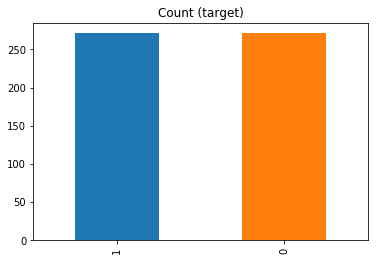

In [14]:
df_class_1_under = df_class_1.sample(count_class_1)
df_test_under = pd.concat([df_class_1_under, df_class_0], axis=0)

print('Random under-sampling:')
print(df_test_under.Upvote_class.value_counts())

df_test_under.Upvote_class.value_counts().plot(kind='bar', title='Count (target)');

In [15]:
df_test_under.shape

(542, 15)

## New dataframe having only helpful and asin features

__Creating new dataframes to obtain better results from our models__

In [16]:
df = df_test_under

In [17]:
df.shape

(542, 15)

In [18]:
helpfulness = df[['helpful','asin']]

In [19]:
helpfulness.head()

,helpful,asin
63528,"[1, 1]",B005XF2HH6
41530,"[44, 47]",B004UP491W
33362,"[1, 1]",B004E10KFG
176661,"[1, 1]",B00EZD91YO
11958,"[12, 13]",B002OLM56K


In [20]:
df2 = pd.DataFrame(helpfulness)

In [21]:
df2[['helpful','total']] = pd.DataFrame(df2.helpful.values.tolist(), index=df2.index)
dfhelpful = df2[['asin', 'helpful','total']]

In [22]:
dfhelpful.head()

,asin,helpful,total
63528,B005XF2HH6,1,1
41530,B004UP491W,44,47
33362,B004E10KFG,1,1
176661,B00EZD91YO,1,1
11958,B002OLM56K,12,13


In [23]:
dfNew = df.drop('helpful',1)

In [24]:
frames = [dfNew, dfhelpful]

In [25]:
result = dfNew.join(dfhelpful[['helpful','total']])

In [26]:
result.head()

,asin,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,HelpfulnessNumerator,HelpfulnessDenominator,Helpful %,% Upvote,Id,Upvote_class,helpful,total
63528,B005XF2HH6,5,I bought these for my boyfriends new phone and...,"03 19, 2013",A28UJBAAYJ93UB,Christa,Screen protectors,1363651200,1,1,1.000000,80-100%,63528,1,1,1
41530,B004UP491W,5,I tested I 6000mAh PowerGen external battery p...,"11 12, 2012",A2D1LPEUCTNT8X,Ali Julia,"Review for use with Nexus 7 Tab, Galaxy Nexus ...",1352678400,44,47,0.936170,80-100%,41530,1,44,47
33362,B004E10KFG,4,I got the Jambox as a birthday present. I have...,"05 14, 2013",A1OMNOPD5QSS1F,Dmitriy Zak,Pricey for its size but it packs a punch,1368489600,1,1,1.000000,80-100%,33362,1,1,1
176661,B00EZD91YO,3,"It's just what you'd expect, TPU, grippy sides...","10 12, 2013",A2APEXAV5RMO4J,Simple Buyer,Essentially good,1381536000,1,1,1.000000,80-100%,176661,1,1,1
11958,B002OLM56K,4,"UPDATE: 12/05/2013I still own it, still use it...","06 30, 2010",A3HVU562SSVP8Q,Ms N. Boone,"Attractive, functional, also works great as NO...",1277856000,12,13,0.923077,80-100%,11958,1,12,13


In [27]:
result.to_csv('reviews.csv', sep=',', header=False,index=False)

In [28]:
result.shape

(542, 16)

## Loading csv to SQLite 
Fetch the score and recommendation summary using SQL queries

In [29]:
result.columns

Index(['asin', 'overall', 'reviewText', 'reviewTime', 'reviewerID',
       'reviewerName', 'summary', 'unixReviewTime', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Helpful %', '% Upvote', 'Id', 'Upvote_class',
       'helpful', 'total'],
      dtype='object')

In [30]:
class csvrd(object):
    def csvFile(self):

        self.readFile('reviews.csv')

    def readFile(self, filename):
        conn = sqlite3.connect('amazonReviews.db')
        cur = conn.cursor() 
        cur.execute("""CREATE TABLE IF NOT EXISTS amazonReviews(asin INT,overall INT,reviewText varchar,reviewTime INTEGER, reviewerID varchar,reviewerName varchar,summary varchar,unixReviewTime INTEGER,HelpfulnessNumerator INTEGER,HelpfulnessDenominator INTEGER,Helpful_PC INTEGER,Upvote_PC CATEGORY,Id INTEGER,Upvote_class INTEGER,helpful INT,total INT)""")
        filename.encode('utf-8')
        print("Amazon Reviews table executed")
        with open(filename) as f:
            reader = csv.reader(f)
            for field in reader:
                cur.execute("INSERT INTO amazonReviews VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?);", field)

        print("CSV Loaded into SQLite")
        conn.commit()
        conn.close()

c = csvrd().csvFile()

Amazon Reviews table executed
CSV Loaded into SQLite


## Reading the data from SQLite

In [31]:
con = sqlite3.connect('amazonReviews.db')

pd.read_sql_query("SELECT * FROM amazonReviews LIMIT 5", con)

,asin,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,HelpfulnessNumerator,HelpfulnessDenominator,Helpful_PC,Upvote_PC,Id,Upvote_class,helpful,total
0,B006WC0U0U,5,If you are a person who drops their phone allo...,"03 28, 2013",A1KGSWLUCNUUZ0,Larry D. Hauser,Highly recommend!!,1364428800,1,1,1,80-100%,73484,1,1,1
1,B00HVLNST6,5,When my daughter's Samsung battery expanded an...,"04 10, 2014",A38QD695FZ8MY,k-wash,A great help,1397088000,2,2,1,80-100%,188835,1,2,2
2,B00GM5L83K,5,"I don't understand why it's called a ""hybrid"" ...","03 14, 2014",A2UZOYXCXUVK1S,Christine,"looks great, love it.",1394755200,1,1,1,80-100%,185185,1,1,1
3,B00H3Z9NBM,5,This 2200mAh portable 'juicer' is great for ti...,"06 14, 2014",A2XIM5GIGWOKTC,"Brandon ""Indie Author Book Reviews""","Small size, great value",1402704000,1,1,1,80-100%,187227,1,1,1
4,B003X7INLK,5,Works great with a gophone plan for iPhone. I...,"01 31, 2013",A1CR83IDDGN2QY,WiseGuy541,good deal,1359590400,1,1,1,80-100%,22282,1,1,1


Ignoring the reviews having score equal to 3

In [32]:
reviews = pd.read_sql_query("""
SELECT 
  overall, 
  summary, 
  helpful, 
  total
FROM amazonReviews 
WHERE overall != 3""", con)

In [33]:
reviews.head()

,overall,summary,helpful,total
0,5,Highly recommend!!,1,1
1,5,A great help,2,2
2,5,"looks great, love it.",1,1
3,5,"Small size, great value",1,1
4,5,good deal,1,1


__Sentiment column depicts the numeric score of being positive or negative
usefulScore column depicts the boolean value of total number of votes__

In [34]:
reviews["sentiment"] = reviews["overall"].apply(lambda score: "positive" if score > 3 else "negative")
reviews["usefulScore"] = (reviews["helpful"]/reviews["total"]).apply(lambda n: "useful" if n > 0.8 else "useless")

reviews.head(5)

,overall,summary,helpful,total,sentiment,usefulScore
0,5,Highly recommend!!,1,1,positive,useful
1,5,A great help,2,2,positive,useful
2,5,"looks great, love it.",1,1,positive,useful
3,5,"Small size, great value",1,1,positive,useful
4,5,good deal,1,1,positive,useful


In [35]:
#Rows having overall score equal to 5
reviews[reviews.overall == 5].head(5)

,overall,summary,helpful,total,sentiment,usefulScore
0,5,Highly recommend!!,1,1,positive,useful
1,5,A great help,2,2,positive,useful
2,5,"looks great, love it.",1,1,positive,useful
3,5,"Small size, great value",1,1,positive,useful
4,5,good deal,1,1,positive,useful


In [36]:
#Rows having overall score equal to 1
reviews[reviews.overall == 1].head(5)

,overall,summary,helpful,total,sentiment,usefulScore
638,1,Useless and weak,4,4,negative,useful
726,1,Grantwood has destroyed this case,2,2,negative,useful
782,1,Shady marketing,10,11,negative,useful
805,1,DONT DO IT,1,1,negative,useful
822,1,Not working for my iphone,2,2,negative,useful


In [37]:
reviews.shape

(4402, 6)

## Feature extraction from reviewsText 
Assign new dimension to each word and give the word counts

In [38]:
regEx = re.compile('[^a-z]+')
def cleanReviews(reviewText):
    reviewText = reviewText.lower()
    reviewText = regEx.sub(' ', reviewText).strip()
    return reviewText

reviews["summaryClean"] = reviews["summary"].apply(cleanReviews)

train, test = train_test_split(reviews, test_size=0.2)
print("%d items in training data, %d in test data" % (len(train), len(test)))


3521 items in training data, 881 in test data


In [39]:
train.head()

,overall,summary,helpful,total,sentiment,usefulScore,summaryClean
4286,2,You'll have to deal with Samsung's horrible cu...,4,33,negative,useless,you ll have to deal with samsung s horrible cu...
2974,4,Meat and poultry thermometer,1,8,positive,useless,meat and poultry thermometer
955,1,crappy batteries,1,18,negative,useless,crappy batteries
3759,5,i love this kettle,2,10,positive,useless,i love this kettle
1577,5,Makes Mopping fast & easy,1,1,positive,useful,makes mopping fast easy


### Using TfidfTransformer().fit_transofrm 
to fit the train and test data

In [40]:
countVector = CountVectorizer(min_df = 1, ngram_range = (1, 4))
X_train_counts = countVector.fit_transform(train["summaryClean"])

#applying tfidf to term frequency
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_new_counts = countVector.transform(test["summaryClean"])
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

y_train = train["sentiment"]
y_test = test["sentiment"]

prediction = dict()

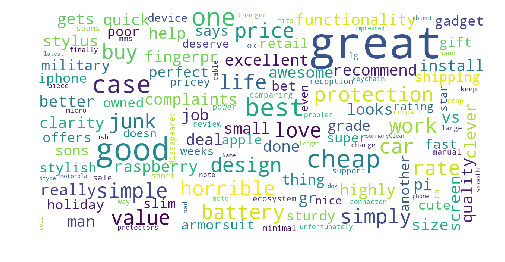

In [41]:
stopwords = set(STOPWORDS)

#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(reviews["summaryClean"])

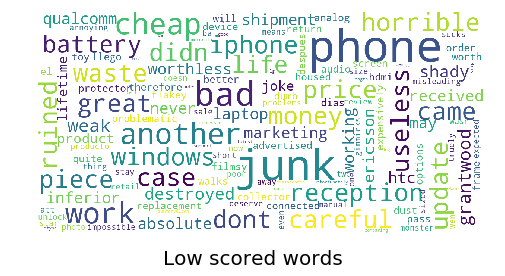

In [42]:
show_wordcloud(reviews[reviews.overall == 1]["summaryClean"], title = "Low scored words")

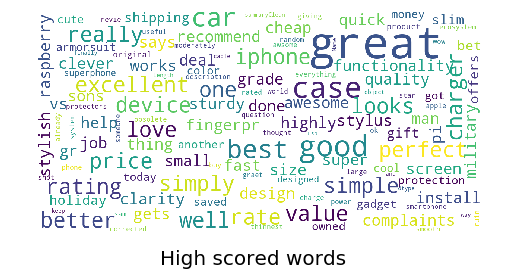

In [43]:
show_wordcloud(reviews[reviews.overall == 5]["summaryClean"], title = "High scored words")

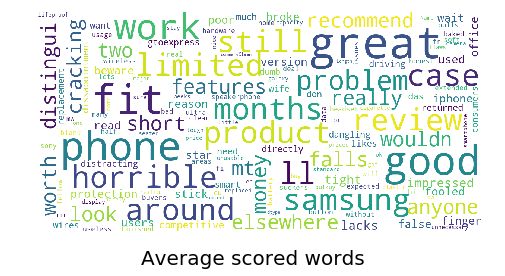

In [44]:
show_wordcloud(reviews[reviews.overall == 2]["summaryClean"], title = "Average scored words")

## Model fitting

### Multinomial Naïve Bayes model

In [45]:
model = MultinomialNB().fit(X_train_tfidf, y_train)
prediction['Multinomial'] = model.predict(X_test_tfidf)

### Bernoulli Naïve Bayes model

In [46]:
model = BernoulliNB().fit(X_train_tfidf, y_train)
prediction['Bernoulli'] = model.predict(X_test_tfidf)

### Logistic regression model

In [47]:
logreg = LogisticRegression(C=1e5)
logreg_result = logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict(X_test_tfidf)

### Results

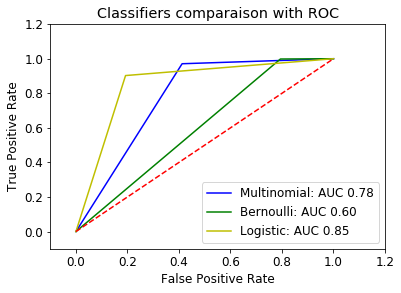

In [48]:
def formatt(x):
    if x == 'negative':
        return 0
    return 1
vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.map(formatt), vfunc(predicted))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Visualize the accuracy, recall and f1-score for Logistic Regression

In [49]:
print(metrics.classification_report(y_test, prediction['Logistic'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.81      0.81      0.81       296
   negative       0.90      0.90      0.90       585

avg / total       0.87      0.87      0.87       881



In [50]:
accuracy_score(y_test, prediction['Logistic'])

0.87060158910329166

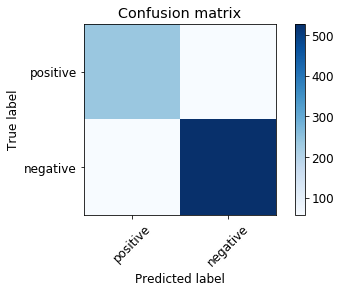

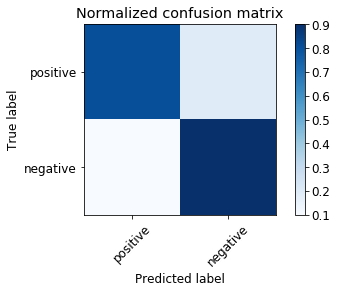

In [51]:
def plot_confusion_matrix(matrix, title='Confusion matrix', cmap=plt.cm.Blues, labels=["positive", "negative"]):
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
matrix = confusion_matrix(y_test, prediction['Logistic'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(matrix)    

matrix_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(matrix_normalized, title='Normalized confusion matrix')
plt.show()

### Visualize the accuracy, recall and f1-score for Naive Bayes Berrnoulli

In [52]:
print(metrics.classification_report(y_test, prediction['Bernoulli'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.98      0.21      0.34       296
   negative       0.71      1.00      0.83       585

avg / total       0.80      0.73      0.67       881



In [53]:
accuracy_score(y_test, prediction['Bernoulli'])

0.73212258796821794

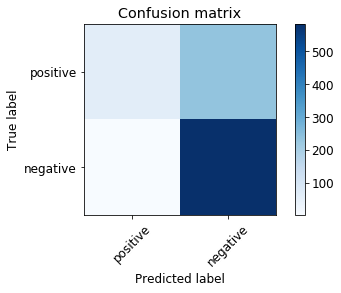

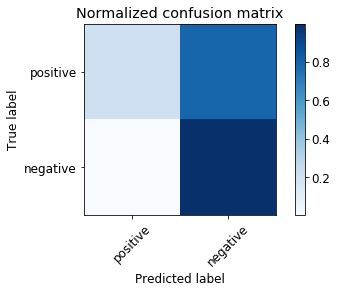

In [54]:
def plot_confusion_matrix(matrix, title='Confusion matrix', cmap=plt.cm.Blues, labels=["positive", "negative"]):
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
matrix = confusion_matrix(y_test, prediction['Bernoulli'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(matrix)    

matrix_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(matrix_normalized, title='Normalized confusion matrix')
plt.show()

### Visualize the accuracy, recall and f1-score for Naive Bayes Multinomial

In [55]:
print(metrics.classification_report(y_test, prediction['Multinomial'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.91      0.59      0.71       296
   negative       0.82      0.97      0.89       585

avg / total       0.85      0.84      0.83       881



In [56]:
accuracy_score(y_test, prediction['Multinomial'])

0.84222474460839958

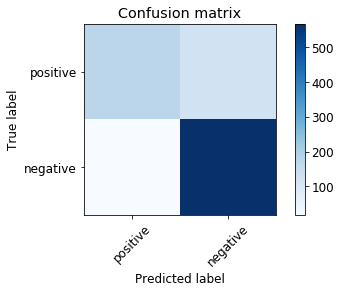

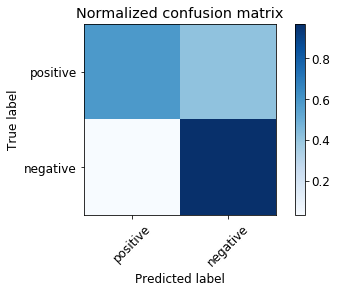

In [57]:
def plot_confusion_matrix(matrix, title='Confusion matrix', cmap=plt.cm.Blues, labels=["positive", "negative"]):
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
matrix = confusion_matrix(y_test, prediction['Multinomial'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(matrix)    

matrix_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(matrix_normalized, title='Normalized confusion matrix')
plt.show()

### Displaying words depicting the best and worst features

In [58]:
features = countVector.get_feature_names()
feature_coefs = pd.DataFrame(
    data = list(zip(features, logreg_result.coef_[0])),
    columns = ['feature', 'coefficient'])

feature_coefs.sort_values(by='coefficient')

,feature,coefficient
14403,not,-42.196185
22104,too,-20.806772
14041,nice but,-20.460630
11414,junk,-19.534256
20224,terrible,-18.497610
16568,poor,-18.471036
5603,doesn,-17.575738
9839,horrible,-17.068321
19560,stars really,-16.768663
2937,broken,-16.135778


### Testing the sentiments of few reviews 

In [59]:
def testSentiments(model, testData):
    testCounts = countVector.transform([testData])
    testTfidf = tfidf_transformer.transform(testCounts)
    result = model.predict(testTfidf)[0]
    probability = model.predict_proba(testTfidf)[0]
    print("Sample estimated as %s: negative prob %f, positive prob %f" % (result.upper(), probability[0], probability[1]))

testSentiments(logreg, "Could have been better.")
testSentiments(logreg, "Just what we expected.")
testSentiments(logreg, "Great, we enjoyed it with my dog!")

Sample estimated as POSITIVE: negative prob 0.004666, positive prob 0.995334
Sample estimated as POSITIVE: negative prob 0.000107, positive prob 0.999893
Sample estimated as POSITIVE: negative prob 0.000513, positive prob 0.999487


# Testing Logistic Regression with another category dataset

In [60]:
df = pd.read_json('Home_and_Kitchen_5.json', lines=True)

In [61]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0615391206,"[0, 0]",5,My daughter wanted this book and the price on ...,"10 19, 2013",APYOBQE6M18AA,Martin Schwartz,Best Price,1382140800
1,0615391206,"[0, 0]",5,I bought this zoku quick pop for my daughterr ...,"06 18, 2014",A1JVQTAGHYOL7F,Michelle Dinh,zoku,1403049600
2,0615391206,"[26, 27]",4,There is no shortage of pop recipes available ...,"05 5, 2013",A3UPYGJKZ0XTU4,mirasreviews,"Excels at Sweet Dessert Pops, but Falls Short ...",1367712000
3,0615391206,"[14, 18]",5,This book is a must have if you get a Zoku (wh...,"08 4, 2011",A2MHCTX43MIMDZ,"M. Johnson ""Tea Lover""",Creative Combos,1312416000
4,0615391206,"[0, 0]",4,This cookbook is great. I have really enjoyed...,"06 7, 2014",AHAI85T5C2DH3,PugLover,A must own if you own the Zoku maker...,1402099200


In [62]:
df[['HelpfulnessNumerator','HelpfulnessDenominator']] = pd.DataFrame(df.helpful.values.tolist(), index = df.index)

In [63]:
#Cleaning the data by eliminating duplicates
df.drop_duplicates(subset=['reviewerID', 'asin','unixReviewTime'],inplace=True)

#Adding the helpfulness and upvote percentages for metrics
df['Helpful %'] = np.where(df['HelpfulnessDenominator'] > 0, df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'], -1)
df['% Upvote'] = pd.cut(df['Helpful %'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest = True)
df['Id'] = df.index

In [64]:
df = df[df['% Upvote'].isin(['0-20%', '20-50%', '50-80%', '80-100%'])]
df.shape

(178270, 14)

In [65]:
# Create mapper
scale_mapper = {'0-20%':0, '20-50%':0, '50-80%':1, '80-100%':1}

In [66]:
# Map feature values to scale
df['Upvote_class'] = df['% Upvote'].replace(scale_mapper)

In [67]:
df.head(1)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,HelpfulnessNumerator,HelpfulnessDenominator,Helpful %,% Upvote,Id,Upvote_class
2,0615391206,"[26, 27]",4,There is no shortage of pop recipes available ...,"05 5, 2013",A3UPYGJKZ0XTU4,mirasreviews,"Excels at Sweet Dessert Pops, but Falls Short ...",1367712000,26,27,0.962963,80-100%,2,1


In [68]:
count_class_0, count_class_1 = df.Upvote_class.value_counts()

In [69]:
# Divide by class
df_class_0 = df[df['Upvote_class'] == 0]
df_class_1 = df[df['Upvote_class'] == 1]

In [70]:
print('Class distribution:')
print('0:', len(df_class_0.axes[0]))
print('1:', len(df_class_1.axes[0]))

Class distribution:
0: 1366
1: 176904


Random under-sampling:
1    1366
0    1366
Name: Upvote_class, dtype: int64


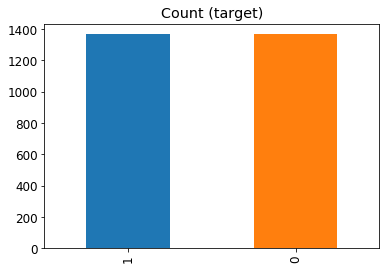

In [71]:
df_class_1_under = df_class_1.sample(count_class_1)
df_test_under = pd.concat([df_class_1_under, df_class_0], axis=0)

print('Random under-sampling:')
print(df_test_under.Upvote_class.value_counts())

df_test_under.Upvote_class.value_counts().plot(kind='bar', title='Count (target)');

In [72]:
df_test_under.shape

(2732, 15)

## New dataframe having only helpful and asin features

In [73]:
df = df_test_under

In [74]:
df.shape

(2732, 15)

In [75]:
helpfulness = df[['helpful','asin']]

In [76]:
helpfulness.head()

,helpful,asin
122397,"[1, 1]",B000A790X6
434173,"[1, 1]",B0058E3CR6
204689,"[1, 1]",B000S8O9ME
100562,"[3, 3]",B00063RXQK
47123,"[3, 3]",B00008GSA4


In [77]:
df2 = pd.DataFrame(helpfulness)

In [78]:
df2[['helpful','total']] = pd.DataFrame(df2.helpful.values.tolist(), index=df2.index)
dfhelpful = df2[['asin', 'helpful','total']]

In [79]:
dfhelpful.head()

,asin,helpful,total
122397,B000A790X6,1,1
434173,B0058E3CR6,1,1
204689,B000S8O9ME,1,1
100562,B00063RXQK,3,3
47123,B00008GSA4,3,3


In [80]:
dfNew = df.drop('helpful',1)

In [81]:
frames = [dfNew, dfhelpful]

In [82]:
result = dfNew.join(dfhelpful[['helpful','total']])

In [83]:
result.head()

,asin,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,HelpfulnessNumerator,HelpfulnessDenominator,Helpful %,% Upvote,Id,Upvote_class,helpful,total
122397,B000A790X6,5,It took me a long time to decide on a kettle. ...,"11 15, 2010",A3JWVI311F2P8C,hl1000,One of the best items ever I ever bought,1289779200,1,1,1.0,80-100%,122397,1,1,1
434173,B0058E3CR6,2,These cups are very nice looking but for every...,"01 22, 2013",ABGJAV24BYFYF,Joan Napolitano,Nice looking but not functional.,1358812800,1,1,1.0,80-100%,434173,1,1,1
204689,B000S8O9ME,4,I had ankle surgery in December 2011 and neede...,"03 10, 2012",ALGVS2M0YPE1V,"D. M. Wright ""angelbyte""",Good temporary solution,1331337600,1,1,1.0,80-100%,204689,1,1,1
100562,B00063RXQK,5,I grew up watching my mother and grandmothers ...,"02 24, 2012",A165LPPCW6TKPH,Lapin Grand-mre,Perfection,1330041600,3,3,1.0,80-100%,100562,1,3,3
47123,B00008GSA4,5,If you start processing your smoothie with the...,"07 25, 2010",A2W4MPQCBKS9AZ,MoeRoe from MA,"make SMOOTHIES if ..,",1280016000,3,3,1.0,80-100%,47123,1,3,3


In [84]:
result.to_csv('reviews.csv', sep=',', header=False,index=False)

In [85]:
result.shape

(2732, 16)

## Loading csv to SQLite 
Fetch the score and recommendation summary using SQL queries

In [86]:
result.columns

Index(['asin', 'overall', 'reviewText', 'reviewTime', 'reviewerID',
       'reviewerName', 'summary', 'unixReviewTime', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Helpful %', '% Upvote', 'Id', 'Upvote_class',
       'helpful', 'total'],
      dtype='object')

In [87]:
class csvrd(object):
    def csvFile(self):

        self.readFile('reviews.csv')

    def readFile(self, filename):
        conn = sqlite3.connect('amazonReviews.db')
        cur = conn.cursor() 
        cur.execute("""CREATE TABLE IF NOT EXISTS amazonReviews(asin INT,overall INT,reviewText varchar,reviewTime INTEGER, reviewerID varchar,reviewerName varchar,summary varchar,unixReviewTime INTEGER,HelpfulnessNumerator INTEGER,HelpfulnessDenominator INTEGER,Helpful_PC INTEGER,Upvote_PC CATEGORY,Id INTEGER,Upvote_class INTEGER,helpful INT,total INT)""")
        filename.encode('utf-8')
        print("Amazon Reviews table executed")
        with open(filename) as f:
            reader = csv.reader(f)
            for field in reader:
                cur.execute("INSERT INTO amazonReviews VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?);", field)

        print("CSV Loaded into SQLite")
        conn.commit()
        conn.close()

c = csvrd().csvFile()

Amazon Reviews table executed
CSV Loaded into SQLite


## Reading the data from SQLite

In [88]:
con = sqlite3.connect('amazonReviews.db')

pd.read_sql_query("SELECT * FROM amazonReviews LIMIT 5", con)

,asin,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,HelpfulnessNumerator,HelpfulnessDenominator,Helpful_PC,Upvote_PC,Id,Upvote_class,helpful,total
0,B006WC0U0U,5,If you are a person who drops their phone allo...,"03 28, 2013",A1KGSWLUCNUUZ0,Larry D. Hauser,Highly recommend!!,1364428800,1,1,1,80-100%,73484,1,1,1
1,B00HVLNST6,5,When my daughter's Samsung battery expanded an...,"04 10, 2014",A38QD695FZ8MY,k-wash,A great help,1397088000,2,2,1,80-100%,188835,1,2,2
2,B00GM5L83K,5,"I don't understand why it's called a ""hybrid"" ...","03 14, 2014",A2UZOYXCXUVK1S,Christine,"looks great, love it.",1394755200,1,1,1,80-100%,185185,1,1,1
3,B00H3Z9NBM,5,This 2200mAh portable 'juicer' is great for ti...,"06 14, 2014",A2XIM5GIGWOKTC,"Brandon ""Indie Author Book Reviews""","Small size, great value",1402704000,1,1,1,80-100%,187227,1,1,1
4,B003X7INLK,5,Works great with a gophone plan for iPhone. I...,"01 31, 2013",A1CR83IDDGN2QY,WiseGuy541,good deal,1359590400,1,1,1,80-100%,22282,1,1,1


Ignoring the reviews having score equal to 3

In [89]:
reviews = pd.read_sql_query("""
SELECT 
  overall, 
  summary, 
  helpful, 
  total
FROM amazonReviews 
WHERE overall != 3""", con)

In [90]:
reviews.head(5)

,overall,summary,helpful,total
0,5,Highly recommend!!,1,1
1,5,A great help,2,2
2,5,"looks great, love it.",1,1
3,5,"Small size, great value",1,1
4,5,good deal,1,1


Sentiment column depicts the numeric score of being positive or negative
usefulScore column depicts the boolean value of total number of votes

In [91]:
reviews["sentiment"] = reviews["overall"].apply(lambda score: "positive" if score > 3 else "negative")
reviews["usefulScore"] = (reviews["helpful"]/reviews["total"]).apply(lambda n: "useful" if n > 0.8 else "useless")

reviews.head(5)

,overall,summary,helpful,total,sentiment,usefulScore
0,5,Highly recommend!!,1,1,positive,useful
1,5,A great help,2,2,positive,useful
2,5,"looks great, love it.",1,1,positive,useful
3,5,"Small size, great value",1,1,positive,useful
4,5,good deal,1,1,positive,useful


In [92]:
#Rows having overall score equal to 5
reviews[reviews.overall == 5].head(5)

,overall,summary,helpful,total,sentiment,usefulScore
0,5,Highly recommend!!,1,1,positive,useful
1,5,A great help,2,2,positive,useful
2,5,"looks great, love it.",1,1,positive,useful
3,5,"Small size, great value",1,1,positive,useful
4,5,good deal,1,1,positive,useful


In [93]:
#Rows having overall score equal to 1
reviews[reviews.overall == 1].head(5)

,overall,summary,helpful,total,sentiment,usefulScore
638,1,Useless and weak,4,4,negative,useful
726,1,Grantwood has destroyed this case,2,2,negative,useful
782,1,Shady marketing,10,11,negative,useful
805,1,DONT DO IT,1,1,negative,useful
822,1,Not working for my iphone,2,2,negative,useful


## Feature extraction from reviewsText 
Assign new dimension to each word and give the word counts

In [94]:
regEx = re.compile('[^a-z]+')
def cleanReviews(reviewText):
    reviewText = reviewText.lower()
    reviewText = regEx.sub(' ', reviewText).strip()
    return reviewText

reviews["summaryClean"] = reviews["summary"].apply(cleanReviews)

train, test = train_test_split(reviews, test_size=0.2)
print("%d items in training data, %d in test data" % (len(train), len(test)))


5410 items in training data, 1353 in test data


In [95]:
train.head()

,overall,summary,helpful,total,sentiment,usefulScore,summaryClean
5922,4,Frother is great DHL is the worst,2,14,positive,useless,frother is great dhl is the worst
1635,5,Stores all your awesomeness,1,1,positive,useful,stores all your awesomeness
4262,4,Car Charger for Samsung Galaxy S3 - USB (Micro...,1,6,positive,useless,car charger for samsung galaxy s usb micro pin...
3860,1,Cannot cook in shards,1,19,negative,useless,cannot cook in shards
4836,5,Hi Yah! Cool,1,1,positive,useful,hi yah cool


### Using TfidfTransformer().fit_transofrm 
to fit the train and test data

In [96]:
countVector = CountVectorizer(min_df = 1, ngram_range = (1, 4))
X_train_counts = countVector.fit_transform(train["summaryClean"])

#applying tfidf to term frequency
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_new_counts = countVector.transform(test["summaryClean"])
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

y_train = train["sentiment"]
y_test = test["sentiment"]

prediction = dict()

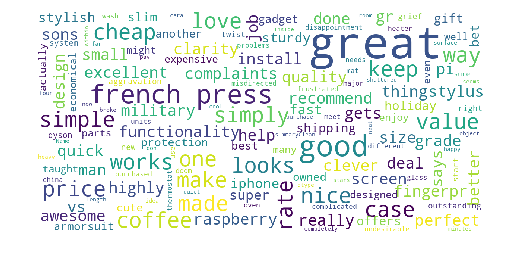

In [97]:
stopwords = set(STOPWORDS)

#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(reviews["summaryClean"])

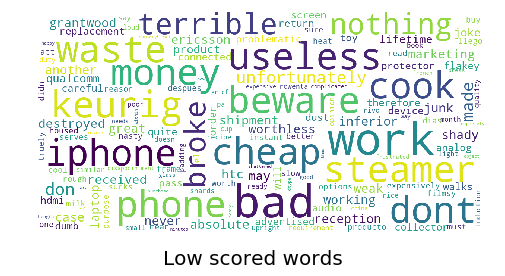

In [98]:
show_wordcloud(reviews[reviews.overall == 1]["summaryClean"], title = "Low scored words")

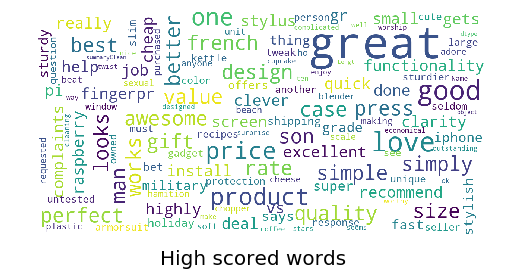

In [99]:
show_wordcloud(reviews[reviews.overall == 5]["summaryClean"], title = "High scored words")

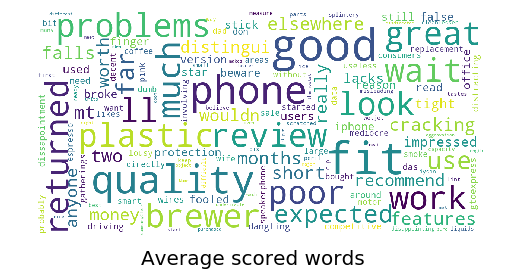

In [100]:
show_wordcloud(reviews[reviews.overall == 2]["summaryClean"], title = "Average scored words")

## Logistic regression model

In [101]:
logreg = LogisticRegression(C=1e5)
logreg_result = logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict(X_test_tfidf)

### Results

### Visualize the accuracy, recall and f1-score for Logistic Regression

In [102]:
print(metrics.classification_report(y_test, prediction['Logistic'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.91      0.91      0.91       534
   negative       0.94      0.94      0.94       819

avg / total       0.93      0.93      0.93      1353



In [103]:
accuracy_score(y_test, prediction['Logistic'])

0.93052475979305249

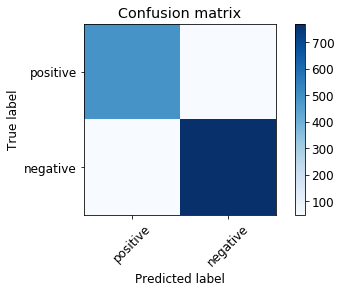

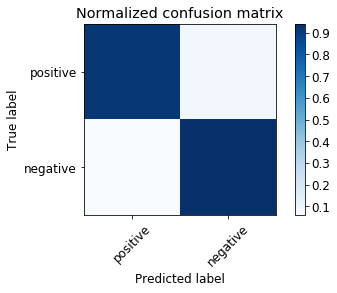

In [104]:
def plot_confusion_matrix(matrix, title='Confusion matrix', cmap=plt.cm.Blues, labels=["positive", "negative"]):
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
matrix = confusion_matrix(y_test, prediction['Logistic'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(matrix)    

matrix_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(matrix_normalized, title='Normalized confusion matrix')
plt.show()

### Displaying words depicting the best and worst features

In [105]:
features = countVector.get_feature_names()
feature_coefs = pd.DataFrame(
    data = list(zip(features, logreg_result.coef_[0])),
    columns = ['feature', 'coefficient'])

feature_coefs.sort_values(by='coefficient')

,feature,coefficient
18871,not,-42.945190
26390,terrible,-21.533626
18401,nice but,-21.095830
21626,poor,-20.427236
14847,junk,-19.045366
28878,too,-18.167884
7143,doesn,-18.049842
29866,useless,-18.012783
25520,stars really,-17.674044
6344,dangerous,-16.887353


### Testing the sentiments of few reviews 

In [106]:
def testSentiments(model, testData):
    testCounts = countVector.transform([testData])
    testTfidf = tfidf_transformer.transform(testCounts)
    result = model.predict(testTfidf)[0]
    probability = model.predict_proba(testTfidf)[0]
    print("Sample estimated as %s: negative prob %f, positive prob %f" % (result.upper(), probability[0], probability[1]))

testSentiments(logreg, "Could have been better.")
testSentiments(logreg, "Just what we expected.")
testSentiments(logreg, "Great, we enjoyed it with my dog!")

Sample estimated as POSITIVE: negative prob 0.000273, positive prob 0.999727
Sample estimated as POSITIVE: negative prob 0.000041, positive prob 0.999959
Sample estimated as POSITIVE: negative prob 0.000009, positive prob 0.999991


## Conclusion

We carried out the steps described in the initial part of this documents and tested three models to predict if a review is positive or negative just based on its text. Logistic regression resulted as the one performing the best. We applyied the same procedure to a dataset of a different category, and the accuracy was of 93 per cent. Resampling our data helped in having a more accurate and belivable result.